In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
bike_data_raw = pd.read_csv('daily-bike-share.csv')

In [3]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)

In [21]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

cv = KFold(n_splits=5, shuffle=False)

X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions = final_polynomial_regression_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')

C:\Users\sabin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sabin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.883e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 3, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.8} 

RMSE: 443.20859630293944


In [12]:
# R^2
train_predictions = final_polynomial_regression_model.predict(X_train)
print(f'Train R^2: {r2_score(y_train, train_predictions)}')

Train R^2: 0.7602219535553051


In [13]:
# MAE
print(f'Train MAE: {mean_absolute_error(y_train, train_predictions)}')
print(f'Test MAE: {mean_absolute_error(y_test, predictions)}')

Train MAE: 242.22573283573016
Test MAE: 333.50266382459176


In [20]:
# MAPE
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, train_predictions)}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, predictions)}')

Train MAPE: 0.8023294825631938
Test MAPE: 2.150036686328407


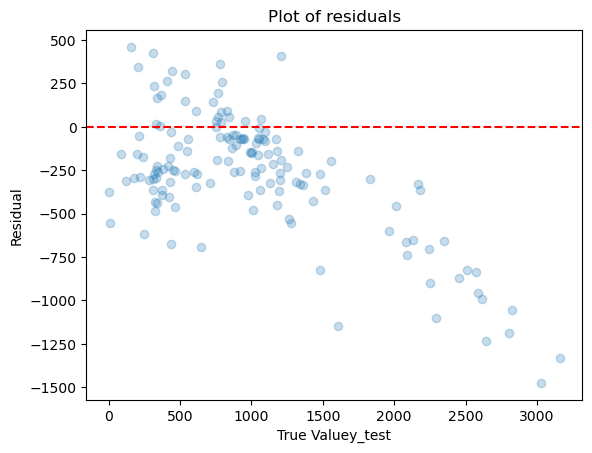

In [27]:
# Wykres reszt
errors = predictions - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Valuey_test')
plt.ylabel('Residual')
plt.title(f'Plot of residuals')
plt.show()

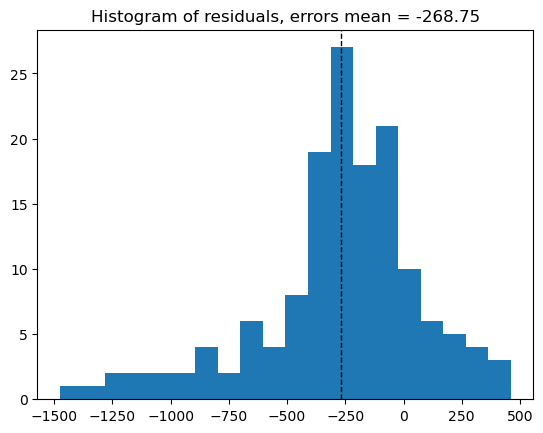

In [28]:
# Histogram reszt
plt.hist(errors, bins = 20)
plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title(f'Histogram of residuals, errors mean = {np.round(errors.mean(), 2)}')
plt.show()

In [34]:
print(f'Porównanie metryk:\n')
print(f'Współczynnik determinacji (R^2):\nPierwszy model ma niższy współczynnik determinacji (R^2 = 0.3062), co oznacza, że mniej zmienności w danych jest wyjaśniane przez ten model. Drugi model ma znacznie wyższy współczynnik determinacji (R^2 = 0.7602), co sugeruje, że lepiej dopasowuje się do danych treningowych.')
print(f'Średni błąd absolutny (MAE):\nPierwszy model ma wyższy błąd średni bezwzględny na danych testowych (MAE = 391.029), co oznacza, że jest mniej dokładny w przewidywaniach. Natomiast drugi model ma niższy MAE (MAE = 333.503), co sugeruje, że jest dokładniejszy.')
print(f'Średni błąd procentowy (MAPE):\nPierwszy model ma wyższy średni błąd procentowy na danych testowych (MAPE = 2.9865), podczas gdy drugi model ma niższy MAPE (MAPE = 2.1500).')
print(f'Błąd średniokwadratowy (RMSE):\nPodobnie jak w przypadku MAE, pierwszy model ma wyższy błąd średniokwadratowy na danych testowych (RMSE = 630.132), a drugi model ma niższy RMSE (RMSE = 443.209).')
print('Na podstawie tych wyników drugi model wydaje się być lepszy od pierwszego modelu. Ma wyższy współczynnik determinacji, niższe błędy RMSE, MAE i MAPE na danych testowych. Oznacza to, że drugi model lepiej dopasowuje się do danych testowych i ma niższe błędy predykcji.')

Porównanie metryk:

Współczynnik determinacji (R^2):
Pierwszy model ma niższy współczynnik determinacji (R^2 = 0.3062), co oznacza, że mniej zmienności w danych jest wyjaśniane przez ten model. Drugi model ma znacznie wyższy współczynnik determinacji (R^2 = 0.7602), co sugeruje, że lepiej dopasowuje się do danych treningowych.
Średni błąd absolutny (MAE):
Pierwszy model ma wyższy błąd średni bezwzględny na danych testowych (MAE = 391.029), co oznacza, że jest mniej dokładny w przewidywaniach. Natomiast drugi model ma niższy MAE (MAE = 333.503), co sugeruje, że jest dokładniejszy.
Średni błąd procentowy (MAPE):
Pierwszy model ma wyższy średni błąd procentowy na danych testowych (MAPE = 2.9865), podczas gdy drugi model ma niższy MAPE (MAPE = 2.1500).
Błąd średniokwadratowy (RMSE):
Podobnie jak w przypadku MAE, pierwszy model ma wyższy błąd średniokwadratowy na danych testowych (RMSE = 630.132), a drugi model ma niższy RMSE (RMSE = 443.209).
Na podstawie tych wyników drugi model wydaje si